# Acknowledgements

- Dataset from https://github.com/ieee8023/covid-chestxray-dataset
- COVID-19 Detector code from https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/

# Imports

In [1]:
import pandas as pd
import os

In [2]:
# General libraries
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

# Deep learning libraries
#import keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

#Util Component 1: Confusion matrix report/Accuracy measures
from sklearn.metrics import accuracy_score, confusion_matrix

# disabling warnings
import logging
logging.getLogger('tensorflow').disabled = True #Jordan_note: Disable red warning lines seen at model architecture creation.

# Utility Functions

In [3]:
def renderConfusionMetrics ( ___model, _testData, _testLabels, enableTraining, ___train_gen, ___test_gen, __batch_size, __epochs, hdf5_testSaveFileName ):
    preds = ___model.predict(_testData)

    acc = accuracy_score(_testLabels, np.round(preds))*100
    cm = confusion_matrix(_testLabels, np.round(preds))
    tn, fp, fn, tp = cm.ravel()


    print('\nCONFUSION MATRIX FORMAT ------------------\n')
    print("[true positives    false positives]")
    print("[false negatives    true negatives]\n\n")

    print('CONFUSION MATRIX ------------------')
    print(cm)

    print('\nTEST METRICS ----------------------')
    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    specificity = tn/(tn+fp)*100 #Jordan_note: added specificity calculation 
    print('Accuracy: {}%'.format(acc))
    print('Precision: {}%'.format(precision))
    print('Recall/Sensitivity: {}%'.format(recall)) #Jordan_note: added sensitivity label
    print('Specificity {}%'.format(specificity)) #Jordan_note: added specificity calculation 
    print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


    if enableTraining:
        checkpoint = ModelCheckpoint(filepath=hdf5_testSaveFileName, save_best_only=True, save_weights_only=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


        hist = ___model.fit_generator(
                   ___train_gen, steps_per_epoch=___test_gen.samples // __batch_size, 
                   epochs=__epochs, validation_data=___test_gen, 
                   validation_steps=___test_gen.samples // __batch_size, callbacks=[checkpoint, lr_reduce])

        print('\nTRAIN METRIC ----------------------')
        print('Covid19 Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.savefig('train_val_acc_loss.png')

In [4]:
#Util Component 2:model architecture description
def defineModelArchitecture (_img_dims ):
    # Input layer
    inputs = Input(shape=(_img_dims, _img_dims, 3))

    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    return inputs, output




def process_data(___inputPath, img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=___inputPath+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=___inputPath+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(___inputPath + 'test' + cond)):
            img = cv2.imread(___inputPath+'test'+cond+img,0) #Replace plt.imread, with  gray scale cv2.imread(path,0), so that ui's image load process doesn't throw a pyimage10 error
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels
    

###########
#Util Component 4: Report file distributions
#directoryProcessArray eg, = ['train', 'val', 'test'], in the case that training val and test folders exist in sub-dir for processing.
def reportFileDistributions (___inputPath, directoryProcessArray):
    for _set in directoryProcessArray:
        n_normal = len(os.listdir(___inputPath + _set + '/NORMAL'))
        n_infect = len(os.listdir(___inputPath + _set + '/PNEUMONIA'))
        print('Set: {}, normal images: {}, regular pneumonia images: {}'.format(_set, n_normal, n_infect))

In [5]:
# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# Hyperparameters
img_dims = 150
batch_size = 32

In [7]:
inputs, output = defineModelArchitecture ( img_dims )

# Non-COVID-19 Lung Pneumonia Detection

In [8]:
# Creating model and compiling
model_pneumoniaDetector = Model(inputs=inputs, outputs=output)
model_pneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_pneumoniaDetector.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 720000)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               368640512 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [9]:
input_path_b = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'

In [10]:
# Report file distributions
reportFileDistributions (input_path_b, ['train', 'val', 'test'] )

Set: train, normal images: 1342, regular pneumonia images: 3876
Set: val, normal images: 9, regular pneumonia images: 9
Set: test, normal images: 234, regular pneumonia images: 390


In [11]:
# Getting the data
train_gen, test_gen, test_data_b, test_labels_b = process_data(input_path_b, img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.



CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[  2 232]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 61.858974358974365%
Precision: 62.33766233766234%
Recall/Sensitivity: 98.46153846153847%
Specificity 0.8547008547008548%
F1-score: 76.34194831013917
Train for 19 steps, validate for 19 steps
Epoch 1/10
19/19 [==============================] - 223s 12s/step - loss: 1.7848 - accuracy: 0.6382 - val_loss: 0.6740 - val_accuracy: 0.6234
Epoch 2/10
19/19 [==============================] - 219s 12s/step - loss: 0.6760 - accuracy: 0.6859 - val_loss: 0.6615 - val_accuracy: 0.6234
Epoch 3/10
18/19 [===========================>..] - ETA: 9s - loss: 0.6081 - accuracy: 0.7257 
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
19/19 [==============================] - 219s 12s/step - loss: 0.6114 - accuracy: 0.7270 - val_loss: 0.6487 - val_accuracy: 0

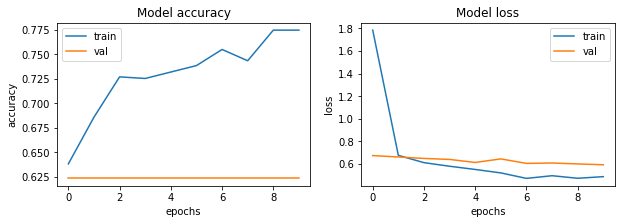

In [12]:
renderConfusionMetrics(model_pneumoniaDetector, test_data_b, test_labels_b, True, train_gen, test_gen, batch_size, 10, 'model_weights.hdf5')


# COVID-19 Lung Pneumonia Detection

In [13]:
inputs, output = defineModelArchitecture(img_dims)

# Creating model and compiling
model_covid19PneumoniaDetector = Model(inputs=inputs, outputs=output)
model_covid19PneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_covid19PneumoniaDetector.load_weights('model_weights.hdf5')

In [14]:
input_path_d = '../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/'

In [15]:
reportFileDistributions (input_path_d, ['train', 'test'])

Set: train, normal images: 74, regular pneumonia images: 74
Set: test, normal images: 20, regular pneumonia images: 20


In [16]:
train_gen_d, test_gen_d, test_data_d, test_labels_d = process_data(input_path_d, img_dims, batch_size)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.



CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[ 0 20]
 [ 0 20]]

TEST METRICS ----------------------
Accuracy: 50.0%
Precision: 50.0%
Recall/Sensitivity: 100.0%
Specificity 0.0%
F1-score: 66.66666666666667
Train for 1 steps, validate for 1 steps
Epoch 1/10
1/1 [==============================] - 18s 18s/step - loss: 1.1358 - accuracy: 0.4500 - val_loss: 0.7021 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 19s 19s/step - loss: 0.8813 - accuracy: 0.5312 - val_loss: 0.6448 - val_accuracy: 0.7500
Epoch 3/10

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1/1 [==============================] - 15s 15s/step - loss: 0.6072 - accuracy: 0.7500 - val_loss: 0.6417 - val_accuracy: 0.8125
Epoch 4/10
1/1 [==============================] - 15s 15s/step - loss: 0.8348 - accuracy: 0.5312 - val_loss: 0.6519 - val_accuracy: 0.7500
Epoch 5

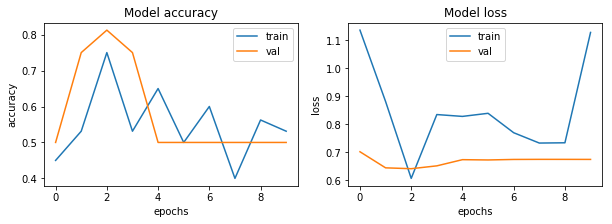

In [17]:
renderConfusionMetrics(model_covid19PneumoniaDetector, test_data_d, test_labels_d, True, train_gen_d, test_gen_d, batch_size, 10, 'covid19_model_weights.hdf5')

# References

[1] Joseph Paul Cohen and Paul Morrison and Lan Dao. COVID-19 image data collection, arXiv, 2020. https://github.com/ieee8023/covid-chestxray-dataset

[2] https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/

## Thank you! I'll be updating this kernel from time to time, when new COVID-19 images come in. Stay safe and happy Kaggling everyone! :)